In [1]:
import pandas
import datetime
import math
import os
import numpy
from scipy import signal, ndimage
from scipy.optimize import curve_fit
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )

selDT = datetime.datetime( 2011, 4, 9, 9, 0 )
anlyzCoords = 'mag'

In [3]:
inpColList = [ "dateStr", "timeStr", "Mlat",\
              "Mlon", "med_tec", "dlat", "dlon" ]
inpFile = "../data/tec-medFilt-20110409.txt"
medFiltTECDF = pandas.read_csv(inpFile, delim_whitespace=True,\
                                    header=None, names=inpColList)
medFiltTECDF["date"] = medFiltTECDF.apply( convert_to_datetime, axis=1 )
medFiltTECDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,800,11.0,34.0,4.9,1.0,2.0,2011-04-09 08:00:00
1,20110409,800,11.0,36.0,7.2,1.0,2.0,2011-04-09 08:00:00
2,20110409,800,11.0,38.0,7.3,1.0,2.0,2011-04-09 08:00:00
3,20110409,800,11.0,64.0,19.0,1.0,2.0,2011-04-09 08:00:00
4,20110409,800,11.0,66.0,19.3,1.0,2.0,2011-04-09 08:00:00


In [4]:
# Analyze the selected time
selTecDF = medFiltTECDF[ medFiltTECDF["date"] == selDT ].reset_index(drop=True)
selTecDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,900,11.0,32.0,10.8,1.0,2.0,2011-04-09 09:00:00
1,20110409,900,11.0,34.0,11.9,1.0,2.0,2011-04-09 09:00:00
2,20110409,900,11.0,70.0,33.0,1.0,2.0,2011-04-09 09:00:00
3,20110409,900,11.0,72.0,34.0,1.0,2.0,2011-04-09 09:00:00
4,20110409,900,11.0,74.0,34.8,1.0,2.0,2011-04-09 09:00:00


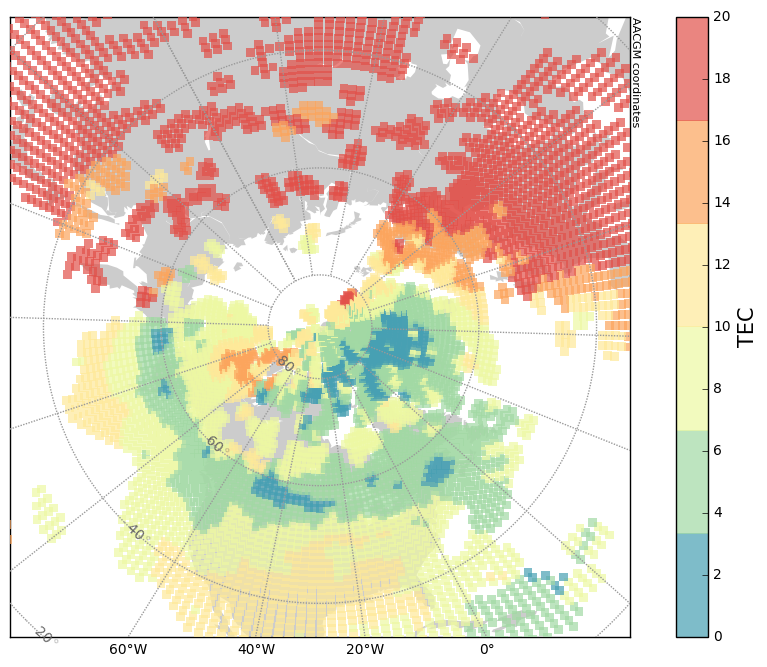

In [5]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords=anlyzCoords, ax=ax, datetime=selDT)
xVec, yVec = m1(list(selTecDF["Mlon"]), list(selTecDF["Mlat"]), coords=anlyzCoords)
# BND data

tecPlot = m1.scatter( xVec, yVec , c=selTecDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=20. )

cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)

In [6]:
def gauss_function(x, a, x0, sigma):
    return a*numpy.exp(-(x-x0)**2/(2*sigma**2))

7.8 320.0 1.86223229866 -2.70979378169 6.43425837901


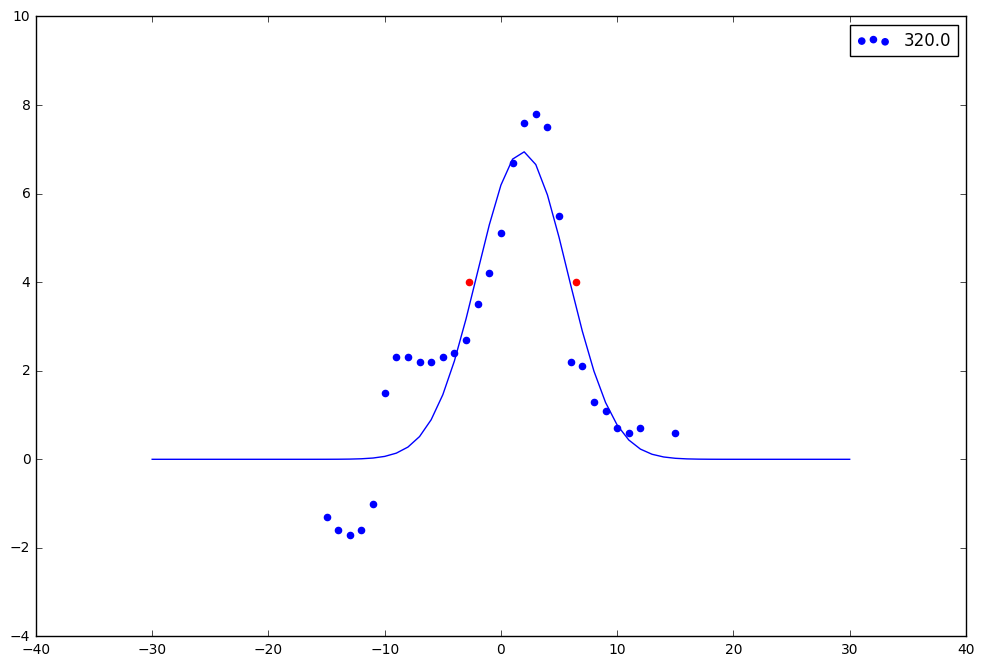

In [58]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
colorList = [ "b", "r", "k" ]
# selMlonList = [ 260., 280., 300., 320., 340., 0., 18. ]
selMlonList = [ 320. ]
for ind, sMlon in enumerate(selMlonList):
    selMlonDF = selTecDF[ (selTecDF["Mlon"] == sMlon) &\
                          (selTecDF["Mlat"] >= 40.) &\
                          (selTecDF["Mlat"] <= 70.)]
    testTECVals = 10-selMlonDF["med_tec"].values
    testMLATVals = numpy.arange(-30, 31)
    popt, pcov = curve_fit(gauss_function, selMlonDF["Mlat"].values-55,\
                           testTECVals, p0 = [2, 10., 1.])
    ax.plot(testMLATVals,\
            gauss_function(testMLATVals, *popt),\
            color=colorList[ind])
    print selMlonDF["med_tec"].median(), sMlon,\
            popt[1], popt[1] - popt[2]*2.355/2., popt[1] + popt[2]*2.355/2.
    ax.scatter( selMlonDF["Mlat"].values-55, testTECVals,label=str(sMlon), color=colorList[ind] )
    ax.scatter( popt[1] - popt[2]*2.355/2., 4., color="r" )
    ax.scatter( popt[1] + popt[2]*2.355/2., 4., color="r" )
ax.legend()